In [1]:
# Load dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pymongo import MongoClient
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Category20c
from math import pi
import plotly.express as px

Import data:
mongoimport --type csv -d SpotifyDataset -c SpotifySongs --headerline --drop project_3_clean.csv

In [2]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [3]:
# confirm database was created
print(mongo.list_database_names())

['admin', 'autosaurus', 'classDB', 'config', 'fruits_db', 'gardenDB', 'local', 'met', 'mydb', 'projectdb', 'spotifydatadb', 'spotifydb', 'travel_db', 'uk_food']


In [4]:
# assign the database to a variable name
spotify_db = mongo['projectdb']

In [7]:
print(spotify_db.list_collection_names())

['mycollection']


In [8]:
# review the collections in our new database
print(spotify_db.list_collection_names())

['mycollection']


In [10]:
# review a document collection
print(spotify_db.mycollection.find_one())

{'_id': ObjectId('6711b143e0b05b632a78cbb9'), 'artist': 'britney spears', 'song': 'oops!...i did it again', 'duration_ms': 211160, 'explicit': 'False', 'year': 2000, 'popularity': 77, 'danceability': 77.02564102564102, 'energy': 83.48348348348348, 'key': 1, 'loudness': -5.444, 'mode': 0, 'speechiness': 7.586805555555556, 'acousticness': 33.59462486002239, 'instrumentalness': 1.77e-05, 'liveness': 41.61781946072685, 'valence': 91.88078108941419, 'tempo': 95.053, 'genre': 'pop', 'duration_minutes': 3.519333333333333}


In [11]:
# assign the collection to a variable
songs = spotify_db['mycollection']

In [12]:
# Display the number of documents 
songs.count_documents({})

1838

### Kimberly's Code: Top 10 Artists by Song Count & Top Artist's Song Popularity Percentages

In [13]:
#Aggregate by artist
artists = [
    { 
        "$group": {
            "_id": "$artist",  # Group by the artist field
            "count": {"$sum": 1}  # Count the number of occurrences of each artist
        }
    },
    { 
        "$sort": {"count": -1}  # Sort by count in descending order
    },
    { 
        "$limit": 10  # Limit the result to the top artist
    }
]
results = list(songs.aggregate(artists))

In [14]:
# Output the top 10 artists with their counts
print("Top 10 artists:")
top_artists = []
for i, artist in enumerate(results, start=1):
    print(f"{i}. {artist['_id']} with {artist['count']} songs.")
    top_artists.append(artist['_id'])  # Store top artist names

Top 10 artists:
1. rihanna with 22 songs.
2. eminem with 21 songs.
3. calvin harris with 20 songs.
4. drake with 19 songs.
5. david guetta with 18 songs.
6. britney spears with 18 songs.
7. katy perry with 16 songs.
8. taylor swift with 16 songs.
9. chris brown with 16 songs.
10. kanye west with 16 songs.


In [15]:
# Extract data for plotting
artist_names = [artist['_id'] for artist in results]
song_counts = [artist['count'] for artist in results]

In [16]:
# Create a DataFrame for the data
data = {
    'Artists': artist_names,
    'Number of Songs': song_counts
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create the bar plot using Plotly Express
top_artist_plot = px.bar(df, x= 'Artists', y= 'Number of Songs', 
             title='Top 10 Artists by Number of Songs',
             labels={'Artists': 'Artists', 'Number of Songs': 'Number of Songs'},
             color='Number of Songs',  # Color by the number of songs
             color_continuous_scale=px.colors.sequential.Greens)  # Color scale

# Show the plot
top_artist_plot.update_layout(xaxis_tickangle=0)  
top_artist_plot.show()

In [17]:
# Save the interactive visualization as an HTML file
top_artist_plot.write_html('Top_10_Artists_by_Number_of_Songs.html')

In [18]:
#Aggregate by popularity
artist_popularity = [
    { 
        "$group": {
            "_id": "$artist",  # Group by the artist field
            "count": { "$sum": 1 },  # Count the number of occurrences of each artist
            "total_popularity": { "$sum": "$popularity" },  # Sum the popularity score for each artist
            "average_popularity": { "$avg": "$popularity" }  # Calculate the average popularity percentage
        }
    },
    { 
        "$sort": { "count": -1 }  # Sort by count in descending order
    },
    { 
        "$limit": 10  # Limit the result to the top 10 artists
    }
]

# Run the aggregation query
popularity_results = list(songs.aggregate(artist_popularity))

In [19]:
# Output the top 10 artists with their counts and average popularity percentage
print("Top 10 artists with average popularity percentage:")
for i, artist in enumerate(popularity_results, start=1):
    print(f"{i}. {artist['_id']}: {artist['count']} songs - Average Popularity: {artist['average_popularity']:.2f}%")

Top 10 artists with average popularity percentage:
1. rihanna: 22 songs - Average Popularity: 72.09%
2. eminem: 21 songs - Average Popularity: 72.33%
3. calvin harris: 20 songs - Average Popularity: 67.80%
4. drake: 19 songs - Average Popularity: 63.79%
5. britney spears: 18 songs - Average Popularity: 63.06%
6. david guetta: 18 songs - Average Popularity: 65.83%
7. taylor swift: 16 songs - Average Popularity: 70.31%
8. kanye west: 16 songs - Average Popularity: 61.44%
9. katy perry: 16 songs - Average Popularity: 64.56%
10. chris brown: 16 songs - Average Popularity: 63.25%


In [20]:
# Convert to DataFrame
popularity_df = pd.DataFrame(popularity_results)

# Rename columns for clarity
popularity_df = popularity_df.rename(columns={
    '_id': 'Artist', 
    'count': 'Song Count', 
    'average_popularity': 'Average Popularity'
})

# Keep only the relevant columns
popularity_df = popularity_df[['Artist', 'Song Count', 'Average Popularity']]

# Create a new column for hover text
popularity_df['Hover Text'] = popularity_df['Song Count'].astype(str) + " songs"

# Create the bubble chart
popularity_plot = px.scatter(popularity_df, x='Artist', y='Average Popularity', 
                    size='Average Popularity',  # Bubble size based on Popularity count *************!!!!!!!!!! PLEASE REVIEW THIS !!!!!!!!!!!!!!!******************
                    color='Average Popularity',  # Color by average popularity
                    hover_data={'Song Count'},  # Include custom hover text
                    title='Top 10 Artists by Number of Songs and Average Popularity',
                    labels={'Song Count': 'Number of Songs', 'Average Popularity': 'Average Popularity (%)'},
                    color_continuous_scale=px.colors.sequential.Greens)  # Color scale

# Show the plot
popularity_plot.show()

In [21]:
# Save the interactive visualization as an HTML file
popularity_plot.write_html('Top_10_Artists_by_Number_of_Songs_and_Popularity.html')

### Dylan's Code: Comparing Danceability vs. Energy of the Top Artist's Songs

In [32]:
selected_artists = [
    "rihanna",  # Replace with actual artist names
    "eminem",
    "calvin harris",
    "drake",
    "britney spears",
    "david guetta",
    "taylor swift",
    "kanye west",
    "katy perry",
    "chris brown"
]

In [34]:
results = list(songs.aggregate([
    {
        '$match': {
            'artist': {'$in': selected_artists}  # Match the selected artists
        }
    },
    {
        '$group': {
            '_id': '$artist',
            'average_danceability': {'$avg': '$danceability'},
            'average_energy': {'$avg': '$energy'}
        }
    }
]))

In [35]:
artists = [result['_id'] for result in results]
average_danceability = [result['average_danceability'] for result in results]
average_energy = [result['average_energy'] for result in results]

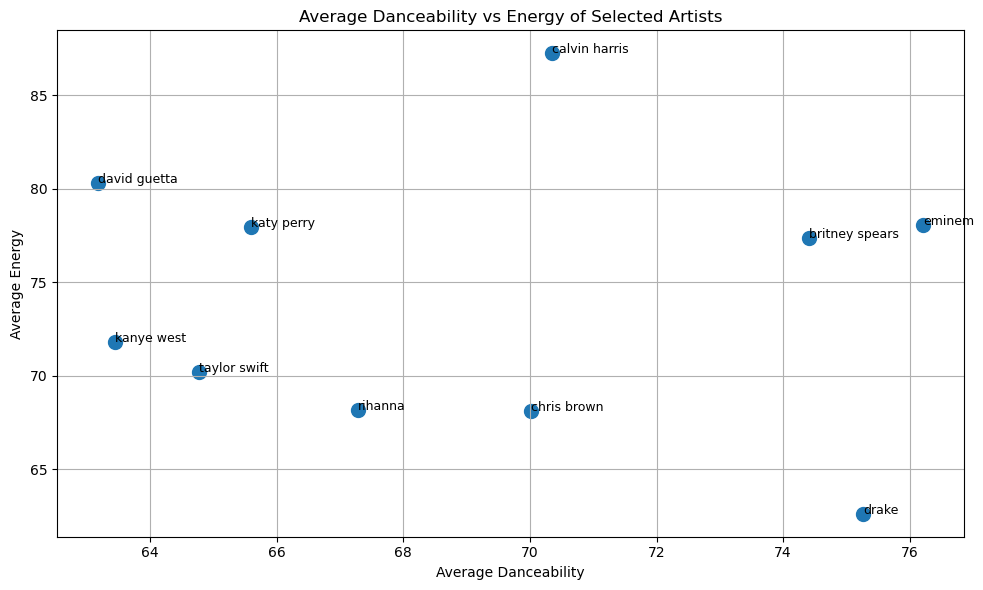

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(average_danceability, average_energy, s=100)  # s is the size of the points

# Annotate points with artist names
for i, artist in enumerate(artists):
    plt.annotate(artist, (average_danceability[i], average_energy[i]), fontsize=9)

# Labels and title
plt.title('Average Danceability vs Energy of Selected Artists')
plt.xlabel('Average Danceability')
plt.ylabel('Average Energy')
plt.grid()

# Show plot
plt.tight_layout()
plt.show()

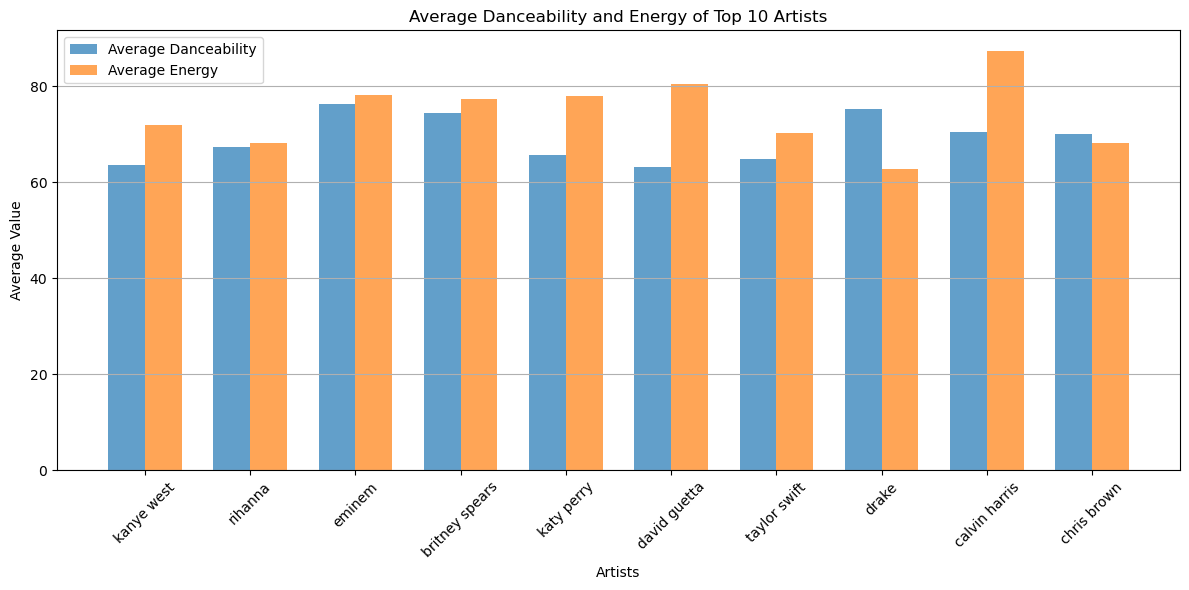

In [37]:
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(artists))

# Create bar charts for danceability and energy
plt.bar(index, average_danceability, bar_width, label='Average Danceability', alpha=0.7)
plt.bar([i + bar_width for i in index], average_energy, bar_width, label='Average Energy', alpha=0.7)

# Labels and title
plt.title('Average Danceability and Energy of Top 10 Artists')
plt.xlabel('Artists')
plt.ylabel('Average Value')
plt.xticks([i + bar_width / 2 for i in index], artists, rotation=45)
plt.legend()
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

In [22]:
# Define the fields for the x and y axes
x_field = 'danceability' 
y_field = 'energy'  

In [23]:
# Fetch data from the songs collection
data = list(songs.find({}, {x_field: 1, y_field: 1}))

In [24]:
# Extract x and y values
x_values = [item[x_field] for item in data]
y_values = [item[y_field] for item in data]

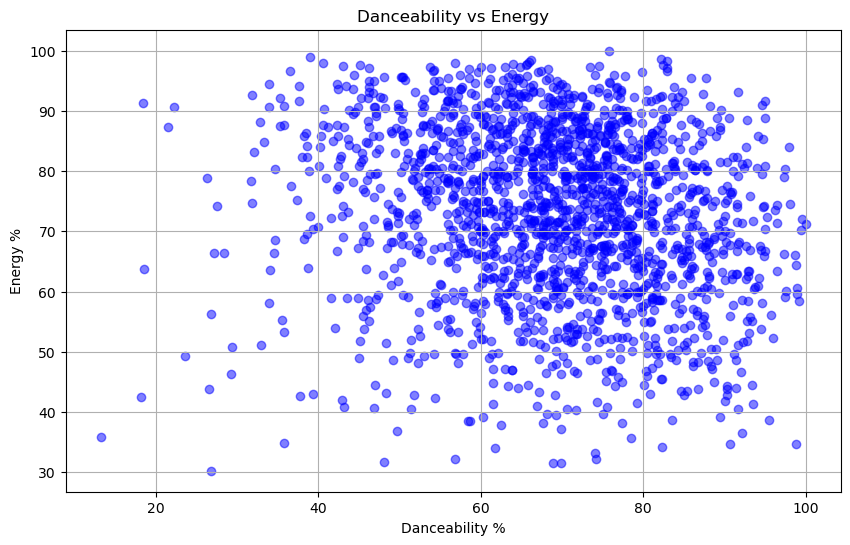

In [25]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, color='blue', alpha=0.5)
plt.title('Danceability vs Energy')
plt.xlabel('Danceability %')
plt.ylabel('Energy %')
plt.grid(True)

# Show the plot
plt.show()

In [40]:
from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [23]:
#Aggregate genre counts
genre_counts = list(songs.aggregate([
    {"$group": {"_id": "$genre", "count": {"$sum": 1}}},  # Group by genre and count
    {"$project": {"genre": "$_id", "count": 1}}  # Reshape the output
]))

In [24]:
#Convert DF 
genre_counts_df = pd.DataFrame(genre_counts)

In [25]:
#Prepare data for Bokeh
genre_counts_df['angle'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 2 * pi
genre_counts_df['color'] = Category20c[len(genre_counts_df)]

In [26]:
#Create the wedge plot
output_notebook()  
p = figure(outer_height=350, title="Song Genres Distribution", toolbar_location=None,
           tools="hover", tooltips="@genre: @count", x_range=(-0.5, 1.0))
p.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True),
         end_angle=cumsum('angle'), line_color="white", fill_color='color', legend_field='genre', 
         source=genre_counts_df)

# Add the circle
p.circle(x=0, y=1, radius=0.2, color="white")

# Adjust axis and grid visibility
p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

# Show the plot
show(p)

Loading BokehJS ...

In [50]:
genre_results = list(songs.aggregate([
    {"$match": {"artist": {"$in": selected_artists}}},  # Filter by selected artists
    {"$group": {"_id": "$genre"}}  # Group by genre
]))

# Step 2: Extract genres from the results
genres = [result['_id'] for result in genre_results]

# Print the list of genres
print("Genres of songs by selected artists:")
print(genres)

Genres of songs by selected artists:
['hip hop', 'pop']


In [51]:
genre_counts = list(songs.aggregate([
    {"$match": {"artist": {"$in": selected_artists}}},  # Filter by selected artists
    {"$group": {"_id": "$genre", "count": {"$sum": 1}}},  # Group by genre and count
    {"$project": {"genre": "$_id", "count": 1}}  # Reshape the output
]))

# Convert to DataFrame and calculate angles for pie chart
genre_counts_df = pd.DataFrame(genre_counts)
genre_counts_df['angle'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 2 * pi
colors = ['red', 'blue'] * (len(genre_counts_df) // 2 + 1)  # Repeat until it covers all genres
genre_counts_df['color'] = colors[:len(genre_counts_df)]  # Ensure it matches the length


# Step 2: Create a pie chart using Bokeh
output_notebook()  # Use this for Jupyter Notebook; use output_file("filename.html") for scripts

p = figure(outer_height=350, title="Genre Distribution of Selected Artists", toolbar_location=None, tools="hover", 
           tooltips="@genre: @count", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True),
         end_angle=cumsum('angle'), line_color="white", fill_color='color', legend_field='genre', 
         source=genre_counts_df)

# Add the circle
p.circle(x=0, y=1, radius=0.2, color="white")

# Adjust axis and grid visibility
p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

# Show the plot
show(p)


Loading BokehJS ...

### Adolphus' Code: Song Popularity Trends by Year and 

In [27]:
# Step 1: Aggregate popularity trends by year and genre
popularity_trends = list(songs.aggregate([
    {
        "$group": {
            "_id": {
                "year": "$year",  # Group by the existing 'year' field
                "genre": "$genre"  # Group by genre
            },
            "average_popularity": {"$avg": "$popularity"}  # Calculate average popularity
        }
    },
    {
        "$project": {
            "year": "$_id.year",
            "genre": "$_id.genre",
            "average_popularity": 1
        }
    },
    {
        "$sort": {
            "year": 1,  # Sort by year
            "genre": 1   # Sort by genre
        }
    }
]))

In [28]:
# Step 2: Convert the aggregation results to a DataFrame
popularity_trends_df = pd.DataFrame(popularity_trends)
# Display the DataFrame
print(popularity_trends_df.head())

                                           _id  average_popularity  year  \
0  {'year': 1999, 'genre': 'Dance/Electronic'}           56.000000  1999   
1           {'year': 1999, 'genre': 'hip hop'}           69.666667  1999   
2               {'year': 1999, 'genre': 'pop'}           62.173913  1999   
3              {'year': 1999, 'genre': 'rock'}           70.166667  1999   
4     {'year': 2000, 'genre': 'Folk/Acoustic'}            0.000000  2000   

              genre  
0  Dance/Electronic  
1           hip hop  
2               pop  
3              rock  
4     Folk/Acoustic  


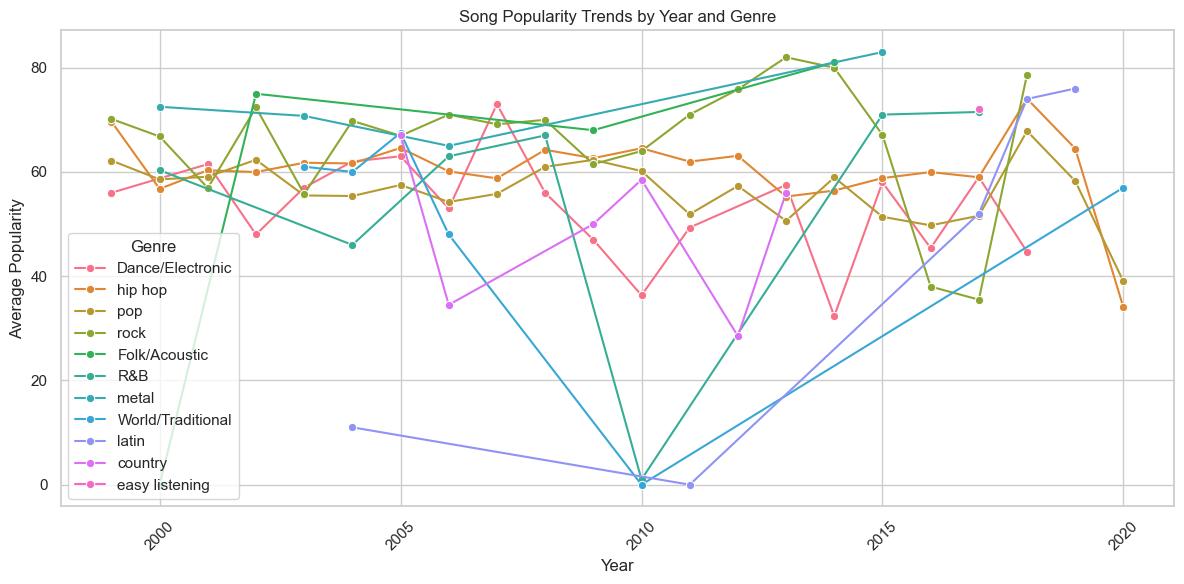

In [29]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
# reate a line plot for popularity trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=popularity_trends_df, x='year', y='average_popularity', hue='genre', marker='o')
plt.title('Song Popularity Trends by Year and Genre')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.legend(title='Genre')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### Sanjana's Code: Comparing Loudness vs. Valence in the Top and Bottom 10% of Songs

In [73]:
# Count the total number of songs
total_songs = songs.count_documents({})
total_songs

1838

In [74]:
# Calculate the number of songs to include in the top 10%
top_10_percent_count = int(total_songs * 0.1)
top_10_percent_count

183

In [75]:
# Query to sort songs by popularity in descending order and limit by top 10% count
top_10_percent_songs = list(
    songs.find({}, {"song": 1, "popularity": 1, "loudness": 1, "valence": 1})  # Include loudness and valence
    .sort("popularity", -1)  # Sort by popularity in descending order
    .limit(top_10_percent_count)  # Limit the results to the top 10% of songs
)

# Output the top 10% songs
print("Top 10% of songs by popularity (ordered by popularity descending):")
for i, song in enumerate(top_10_percent_songs, start=1):
    print(f"{i}. {song['song']} - Popularity: {song['popularity']}%, Loudness: {song['loudness']} dB, Valence: {song['valence']}")


Top 10% of songs by popularity (ordered by popularity descending):
1. sweater weather - Popularity: 89%, Loudness: -2.81 dB, Valence: 40.904419321685516
2. another love - Popularity: 88%, Loudness: -8.532 dB, Valence: 13.463514902363825
3. without me - Popularity: 87%, Loudness: -2.827 dB, Valence: 68.03699897225077
4. wait a minute! - Popularity: 86%, Loudness: -5.279 dB, Valence: 69.06474820143885
5. the real slim shady - Popularity: 86%, Loudness: -4.244 dB, Valence: 78.10894141829394
6. perfect - Popularity: 85%, Loudness: -6.312 dB, Valence: 17.26618705035971
7. 'till i collapse - Popularity: 85%, Loudness: -3.237 dB, Valence: 10.277492291880781
8. circles - Popularity: 85%, Loudness: -3.497 dB, Valence: 56.83453237410072
9. daddy issues - Popularity: 85%, Loudness: -9.461 dB, Valence: 34.635149023638235
10. locked out of heaven - Popularity: 85%, Loudness: -4.165 dB, Valence: 89.10585817060638
11. the nights - Popularity: 85%, Loudness: -5.298 dB, Valence: 67.2147995889003
12. lu

In [76]:
# Calculate the number of songs to include in the bottom 10%
bottom_10_percent_count = int(total_songs * 0.1)
bottom_10_percent_count

183

In [77]:
# Query to sort songs by popularity in ascending order and limit by bottom 10% count
bottom_10_percent_songs = list(
    songs.find({}, {"song": 1, "popularity": 1, "loudness": 1, "valence": 1})  # Include loudness and valence
    .sort("popularity", 1)  # Sort by popularity in ascending order
    .limit(bottom_10_percent_count)  # Limit the results to the bottom 10% of songs
)

# Output the bottom 10% songs
print("Bottom 10% of songs by popularity (ordered by popularity ascending):")
for i, song in enumerate(bottom_10_percent_songs, start=1):
    print(f"{i}. {song['song']} - Popularity: {song['popularity']}%, Loudness: {song['loudness']} dB, Valence: {song['valence']}")

Bottom 10% of songs by popularity (ordered by popularity ascending):
1. stupid girls - Popularity: 0%, Loudness: -5.045 dB, Valence: 58.17060637204522
2. man of the year - Popularity: 0%, Loudness: -5.234 dB, Valence: 40.184994861253855
3. i want you to know - Popularity: 0%, Loudness: -2.215 dB, Valence: 38.54059609455293
4. king - Popularity: 0%, Loudness: -4.125 dB, Valence: 47.893114080164445
5. don't forget about us - radio edit - Popularity: 0%, Loudness: -6.816 dB, Valence: 39.67112024665982
6. team - Popularity: 0%, Loudness: -7.444 dB, Valence: 43.884892086330936
7. ai se eu te pego - live - Popularity: 0%, Loudness: -4.55 dB, Valence: 87.35868448098664
8. there's nothing holdin' me back - Popularity: 0%, Loudness: -4.035 dB, Valence: 99.28057553956835
9. hurts so good - Popularity: 0%, Loudness: -5.008 dB, Valence: 38.951695786228164
10. sugar - Popularity: 0%, Loudness: -7.077 dB, Valence: 90.95580678314492
11. bottoms up (feat. nicki minaj) - Popularity: 0%, Loudness: -5.28

In [78]:
# Convert the top 10% of songs to a DataFrame
top_songs_df = pd.DataFrame(top_10_percent_songs)

- loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


In [79]:
# Plot for Top 10% songs
fig_top = px.scatter(top_songs_df, x='loudness', y='valence', 
                     color='popularity', 
                     title="Top 10% Most Popular Songs: Loudness vs Valence",
                     labels={'loudness': 'Loudness (dB)', 'valence': 'Valence (Positivity)'},
                     hover_name='song',  # Use the song title for hover text
                     size='popularity',
                     color_continuous_scale=px.colors.sequential.Greens,
                     template='plotly_dark')

# Show plot
fig_top.show()

In [80]:
# Convert the bottom 10% of songs to a DataFrame
bottom_songs_df = pd.DataFrame(bottom_10_percent_songs)

In [82]:
# Plot for Bottom 10% songs
fig_bottom = px.scatter(bottom_songs_df, x='loudness', y='valence', 
                        color='popularity', 
                        title="Bottom 10% Least Popular Songs: Loudness vs Valence",
                        labels={'loudness': 'Loudness (dB)', 'valence': 'Valence (Positivity)'},
                        hover_name='song',  # Use the song title for hover text
                        size='popularity',
                        color_continuous_scale=px.colors.sequential.Greens,
                        template='plotly_dark')

# Show plot
fig_bottom.show()